# Fraud Transaction Prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,roc_curve,classification_report,confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv("Fraud.csv")

In [3]:
df.shape

(6362620, 11)

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Datatypes

In [5]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [6]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## Data Cleaning 

### Check for missing values 

In [9]:
df.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

There are no columns with null values. Therefore the data doesn't contain null values

In [11]:
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


### Removing unnecessary features 

In [12]:
df =  df.drop(['step','nameOrig', 'nameDest'], axis = 1)

### Dealing with multicolinearity 

#### i) Checking multicollinearity in features

In [13]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [14]:
data = { "CASH_OUT":0,
            "PAYMENT":1,
            "CASH_IN":2,
            "TRANSFER":3,
            "DEBIT":4,}

In [15]:
# replacing 'type' columns with new data
df['type'] = df['type'].map(data)

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

In [17]:
x = df.iloc[:,:-1] #select all columns except last column 
calculate_vif(x)

,variables,VIF
0,type,1.465620
1,amount,4.279599
2,oldbalanceOrg,572.366316
3,newbalanceOrig,578.447542
4,oldbalanceDest,73.410905
5,newbalanceDest,85.293086
6,isFraud,1.193484


We can see here that the ‘oldbalanceOrg’ , ‘newbalanceOrig’ , 'oldbalanceDest' and 'newbalanceDest' have a high VIF value, meaning they can be predicted by other independent variables in the dataset.

#### ii) Fixing Multicollinearity

In [18]:
df = df.drop(['oldbalanceOrg' , 'newbalanceOrig' , 'oldbalanceDest' , 'newbalanceDest'],axis=1)

In [19]:
df.isnull().sum()

type              0
amount            0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [20]:
df.duplicated().sum()

731186

### Analyzing the data

In [21]:
df.describe()

,type,amount,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.055307e+00,1.798619e+05,1.290820e-03,2.514687e-06
std,9.808966e-01,6.038582e+05,3.590480e-02,1.585775e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.338957e+04,0.000000e+00,0.000000e+00
50%,1.000000e+00,7.487194e+04,0.000000e+00,0.000000e+00
75%,2.000000e+00,2.087215e+05,0.000000e+00,0.000000e+00
max,4.000000e+00,9.244552e+07,1.000000e+00,1.000000e+00


In [22]:
cols = list(df.columns)
cols

['type', 'amount', 'isFraud', 'isFlaggedFraud']

In [23]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

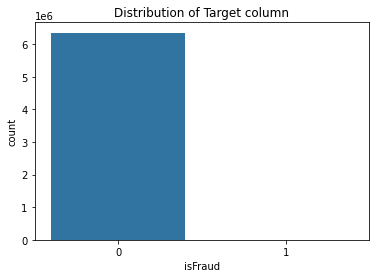

In [24]:
data = df['isFraud'].value_counts()
sns.countplot(df['isFraud'])
plt.title('Distribution of Target column')
plt.show()

Here, We can see that the target column is highly imbalanced. For handling the imabalanced dataset we need to use the SMOTE technique.

### Scalingthe dataset 

Before scaling we'll have to encode all categorical variables to numerical

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            int64  
 1   amount          float64
 2   isFraud         int64  
 3   isFlaggedFraud  int64  
dtypes: float64(1), int64(3)
memory usage: 194.2 MB


Here all columns are numerical. So there is no need to do encoding.

In [26]:
#Dataset before scaling
df

,type,amount,isFraud,isFlaggedFraud
0,1,9839.64,0,0
1,1,1864.28,0,0
2,3,181.00,1,0
3,0,181.00,1,0
4,1,11668.14,0,0
...,...,...,...,...
6362615,0,339682.13,1,0
6362616,3,6311409.28,1,0
6362617,0,6311409.28,1,0
6362618,3,850002.52,1,0


#### Why do we scale datasets?
#### Different features might have different units, ranges, or magnitudes. If we don't scale the features, some variables with larger scales might dominate the learning process, leading to biased results. 
#### Scaling can help machine learning algorithms converge faster.

In [27]:
#making an object of MinMaxScaler() function with name of scaler
scaler = MinMaxScaler()

In [28]:
#fitting the df (dataset) 
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=cols)

In [29]:
#Dataset after scaling
df

,type,amount,isFraud,isFlaggedFraud
0,0.25,0.000106,0.0,0.0
1,0.25,0.000020,0.0,0.0
2,0.75,0.000002,1.0,0.0
3,0.00,0.000002,1.0,0.0
4,0.25,0.000126,0.0,0.0
...,...,...,...,...
6362615,0.00,0.003674,1.0,0.0
6362616,0.75,0.068272,1.0,0.0
6362617,0.00,0.068272,1.0,0.0
6362618,0.75,0.009195,1.0,0.0


### Performing the column_transformations to convert all columns into numerical form

#### i) Applying LabelEncoder to encode the target column

In [30]:
encode = preprocessing.LabelEncoder()   #making an obj of LabelEncoder()
df['isFraud'] = encode.fit_transform(df['isFraud'])  #applying LabelEncoding through fit_transform

In [31]:
x  = df.drop('isFraud', axis='columns')  #features columns
y = df['isFraud'] 

In [32]:
cols

['type', 'amount', 'isFraud', 'isFlaggedFraud']

#### ii) Column Transformation (Categorical to Numerical)

In [33]:
transformer1 = ColumnTransformer(transformers=[
    ('trs1',OneHotEncoder(),['type','amount','isFlaggedFraud'])
],remainder='passthrough')
transformer1

ColumnTransformer(remainder='passthrough',
                  transformers=[('trs1', OneHotEncoder(),
                                 ['type', 'amount', 'isFlaggedFraud'])])

In [34]:
x = transformer1.fit_transform(x)

In [35]:
y.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Applying Smote technique for handling imbalanced data 

In [36]:
from imblearn.over_sampling import SMOTE

In [37]:
# Instantiate SMOTE with desired parameters
smt = SMOTE(sampling_strategy='auto', random_state=42)

In [38]:
x_smt, y_smt = smt.fit_resample(x, y)

In [39]:
y_smt.value_counts()

0    6354407
1    6354407
Name: isFraud, dtype: int64

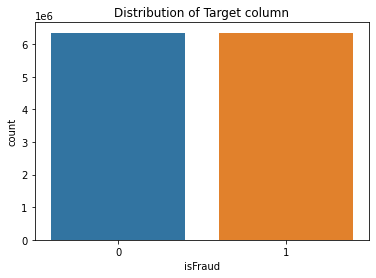

In [40]:
data = y_smt.value_counts()
sns.countplot(y_smt)
plt.title('Distribution of Target column')
plt.show()

In [41]:
x_smt.shape

(12708814, 5316907)

In [42]:
y_smt.shape

(12708814,)

## Modeling 

### Splitting dataset into train and test 

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x_smt, y_smt, test_size=0.20, random_state=0)

### i) Logistic Regression 

In [44]:
from sklearn.linear_model import LogisticRegression 

lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)

LogisticRegression()

In [45]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

y_pred = lr_model.predict(x_test)
accuracy_score(y_test,y_pred)

0.9997167320477952

In [46]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1269605
           1       1.00      1.00      1.00   1272158

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763



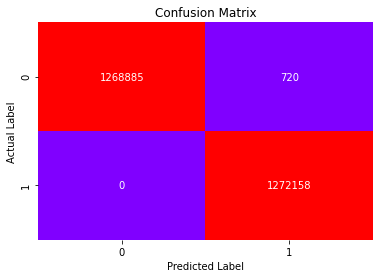

True Negeatives : 1268885
False Positives : 720
False Negeatives : 0
True Positives : 1272158


In [47]:
confusion_matrix(y_test,y_pred)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='d',cbar=False, cmap='rainbow')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

print(f'True Negeatives : {confusion_matrix(y_test,y_pred)[0][0]}')
print(f'False Positives : {confusion_matrix(y_test,y_pred)[0][1]}')
print(f'False Negeatives : {confusion_matrix(y_test,y_pred)[1][0]}')
print(f'True Positives : {confusion_matrix(y_test,y_pred)[1][1]}')

# QUESTIONS

### 1. Data Cleaning 

In the cleaning process, I have checked for null values and there was no null values in the data. Then I dropped unnecessary columns such as step, nameOrig and nameDest. After that I have dealt with Multicollinearity. It was noticed that variables - ‘oldbalanceOrg’ , ‘newbalanceOrig’ , 'oldbalanceDest' and 'newbalanceDest' have a high VIF value, meaning they can be predicted by other independent variables in the dataset. There are not much outliers in the data. So I ignored that part.

### 2. Describe your fraud detection model in elaboration. 


The fraud detection model has been done by the following steps:
    (a) Data cleaning 
    (b) Analyse the data
    (c) Scaling data
    (d) Performing the column_transformations to convert all columns into numerical form
    (e) Smote for dealing the imbalanced data
    (f) Model building : For modeling I did logistic regression. It showed good results.

### 3. How did you select variables to be included in the model?


I dropped the unnecessary columns which are not gives any information for model building and also dropped those columns which have high VarianceInfluenceFactor (VIF). Left four columns ('type', 'amount', 'isFraud', 'isFlaggedFraud') are selected for model building.

### 4. Demonstrate the performance of the model by using best set of tools. 

Accuracy score, Precision, Recall, F1 Score, Confusion metrix can be seen in the above results.

### 5. What are the key factors that predict fraudulent customer?


There is four ('type', 'amount', 'isFraud', 'isFlaggedFraud') most important key factors which predict the fraudulent customer.

### 6. Do these factors make sense? If yes, How? If not, How not? 

Yes, Because these key factors hold the actual and sufficient information for any fraudulent transaction.

### 7. What kind of prevention should be adopted while company update its infrastructure? 

When a company is updating its infrastructure for fraud transaction prediction, several preventive measures can be adopted to enhance the overall security and effectiveness of the system. Here are some important prevention measures to consider:

Multi-factor Authentication (MFA): Implement multi-factor authentication for accessing critical systems and sensitive data. MFA adds an extra layer of security by requiring users to provide additional forms of authentication, such as a one-time password (OTP) sent to their mobile devices, in addition to their regular credentials.

Data Encryption: Ensure that sensitive data, including customer information and transaction details, are encrypted both at rest and in transit. Encryption helps protect data from unauthorized access even if there is a security breach.

Regular Security Audits and Penetration Testing: Conduct regular security audits and penetration testing to identify vulnerabilities in the system. This helps proactively address potential weaknesses before they can be exploited by attackers.

### 8. Assuming these actions have been implemented, how would you determine if they work?

To determine if the preventive actions implemented for fraud transaction prediction are effective, you need to conduct a thorough evaluation and assessment of the system's security and performance. Here are some key steps to measure the effectiveness of the implemented actions:

Performance Metrics: Define and monitor relevant performance metrics for the fraud detection system. Common metrics include accuracy, precision, recall, F1-score, and area under the receiver operating characteristic curve (AUC-ROC). These metrics help evaluate the system's ability to correctly identify fraudulent transactions while minimizing false positives and false negatives.

Real-world Testing: Conduct real-world testing with real transaction data, including both historical and newly generated data. This testing should simulate various fraud scenarios and measure the system's performance under different conditions.

Attack Simulation: Perform penetration testing and security assessments, including attempts to bypass security measures, exploit vulnerabilities, and launch mock attacks. The goal is to identify any weaknesses and vulnerabilities in the system and assess how well the implemented actions resist potential attacks.